<a href="https://colab.research.google.com/github/JennyMyy/Data-analytiikka/blob/main/Oluen_tuotantom%C3%A4%C3%A4r%C3%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Jenny')

Päivitetty 2024-03-17 / Jenny


# Osa 2
### Oluen tuotannon määrä ja ennustaminen

In [43]:
# Luetaan tarvittavat kirjastot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Tarvittavat kirjastot koolminkertaiseen eksponentiaaliin tasoitukseen
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

In [44]:
# Yhdistetään google driveen.

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/data


In [45]:
# Oluen tuotantomäärien Lähde: https://www.kaggle.com/datasets/shenba/time-series-datasets
# Luetaan aineisto
df = pd.read_csv('beer.csv')

df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [46]:
# Muotoillaan vielä dataframe kuukausittain olevaksi aikaleimaksi

df.index=pd.to_datetime(df['Month'], format='%Y-%m')

# Poistetaan ineksisarake, mikä on tarpeeton
df = df.drop('Month', axis = 1)
df

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


<Axes: xlabel='Month'>

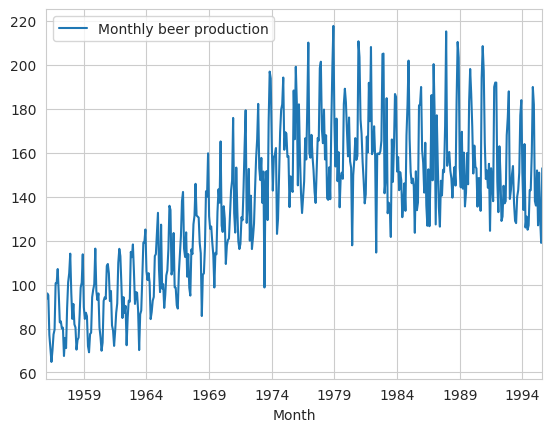

In [47]:
# Piiretään kuva ylläolevasta taulukosta

df.plot()

Nähtävissä on trendi ja kausivaihtelu.

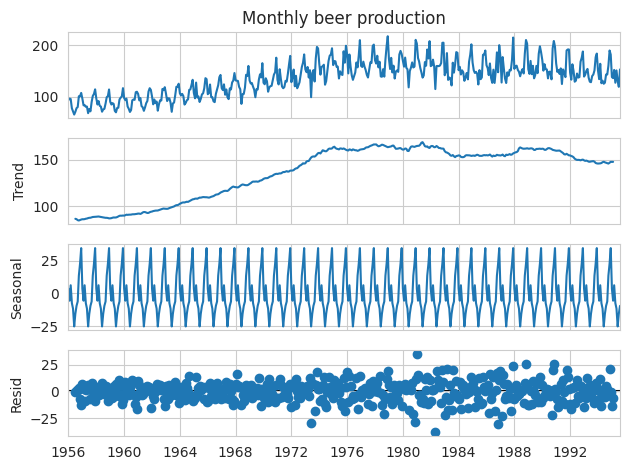

In [48]:
# Katsotaan alkuperäinen aikasarja, trendi ja kausivaihtelu
# Resid jäännös arvot

decompose = seasonal_decompose(df['Monthly beer production']).plot()

Nähtävissä on 1956 vuodesta 1976 vuoteen asti nouseva trendi, minkä jälkeen oluen tuotanto ollut tasaisempaan eli pysynyt melkein samalla tasolla.

Havaittavissa on myös selkeää kausivaihtelua, mikä näkyy säännöllisinä piikkeinä.

Resid nähtävissä jäänösarvot, jotka ovat hyvin lähellä arvoa 0.

# Mallin sovitus

In [49]:
# Jos aineisto sisältää 0 arvoja, korvaa nollasta poikkeavat arvot aikasarjan keskiarvolla
df['Monthly beer production'] = df['Monthly beer production'].replace(0, df['Monthly beer production'].mean())

In [50]:
# Otetaan laskennassa huomioon aineiston olevan kuukaistasolla sekä trendi ja kausivaihtelu

malli = ExponentialSmoothing(df['Monthly beer production'], trend='add', seasonal='mul',
                             seasonal_periods=12).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [51]:
# mallin mukaa simuloidut ennusteet

df['Ennuste'] = malli.fittedvalues
df

,Monthly beer production,Ennuste
Month,,
1956-01-01,93.2,88.024488
1956-02-01,96.0,83.084688
1956-03-01,95.2,91.956006
1956-04-01,77.1,83.620554
1956-05-01,70.9,81.134365
...,...,...
1995-04-01,127.0,135.855629
1995-05-01,151.0,131.396371
1995-06-01,130.0,118.905896


<Axes: xlabel='Month'>

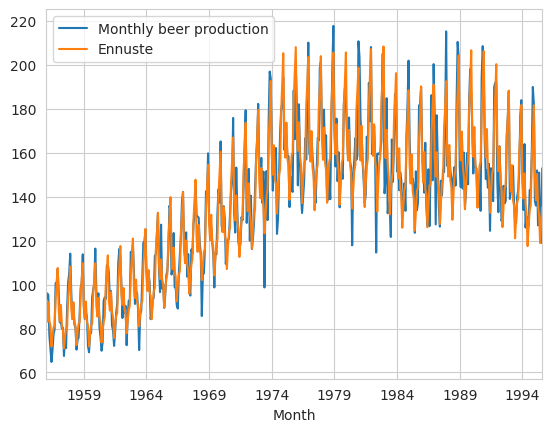

In [52]:
df.plot()

Ennuste arvot ovat lähellä toteutuneita arvoja.

In [53]:
# Ennustevirheet (residuaalit)
df['Ennustevirhe'] = malli.resid
df

,Monthly beer production,Ennuste,Ennustevirhe
Month,,,
1956-01-01,93.2,88.024488,5.175512
1956-02-01,96.0,83.084688,12.915312
1956-03-01,95.2,91.956006,3.243994
1956-04-01,77.1,83.620554,-6.520554
1956-05-01,70.9,81.134365,-10.234365
...,...,...,...
1995-04-01,127.0,135.855629,-8.855629
1995-05-01,151.0,131.396371,19.603629
1995-06-01,130.0,118.905896,11.094104


Text(0, 0.5, 'Ennustevirhe')

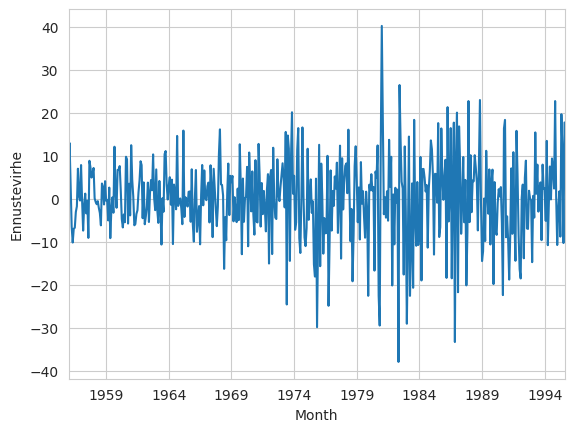

In [54]:
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Ennustevirheiden aikasarjan vaihtelu on sattumanvaraista.

Text(0, 0.5, 'Totetunut oluen tuotanto')

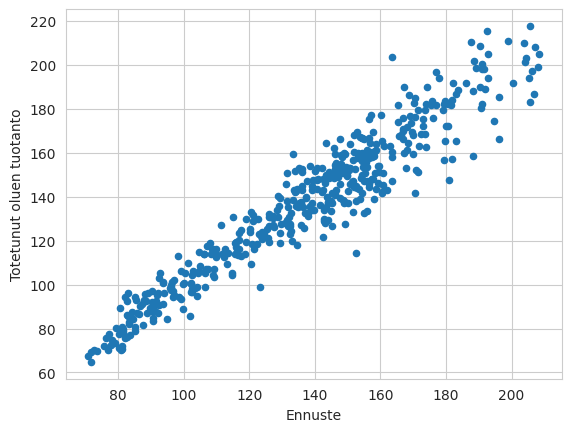

In [55]:
# Ennusteiden ja toteutuneen tuotannon hajontakvaaio
df.plot(kind='scatter', x='Ennuste', y='Monthly beer production')
plt.xlabel('Ennuste')
plt.ylabel('Totetunut oluen tuotanto')

Pisteet ovat lähellä suoraa viivaa alakulmasta yläkulmaan, jolloin malli on luotettava.

In [56]:
# Mallin statistiikka
malli.summary()

Dep. Variable:,Monthly beer production,No. Observations:,476
Model:,ExponentialSmoothing,SSE,44078.699
Optimized:,True,AIC,2187.478
Trend:,Additive,BIC,2254.124
Seasonal:,Multiplicative,AICC,2188.974
Seasonal Periods:,12,Date:,"Sun, 17 Mar 2024"
Box-Cox:,False,Time:,11:35:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0869314,alpha,True
smoothing_trend,0.0860465,beta,True


### Ennusteiden laskeminen

In [57]:
# Tarkistetaan aikasarjan viimeinen aikaleima
df.tail()

,Monthly beer production,Ennuste,Ennustevirhe
Month,,,
1995-04-01,127.0,135.855629,-8.855629
1995-05-01,151.0,131.396371,19.603629
1995-06-01,130.0,118.905896,11.094104
1995-07-01,119.0,129.351617,-10.351617
1995-08-01,153.0,135.314539,17.685461


In [58]:
# Ennuste tulee alkaa kuukauden ensimmäisestä päivästä, jolloin  shift(1, freq='D').
index = pd.date_range('1995-08-01', periods=100, freq='M').shift(1, freq='D')

# Ennustetaan 100 kk eteenpäin
ennusteet = malli.forecast(100)

# Ennusteet dataframeen oma tietokehykseen, missä dataa ei alun perin ole.
df_ennuste = pd.DataFrame(data=ennusteet, index = index, columns=['Ennuste'])
df_ennuste

,Ennuste
1995-09-01,138.973267
1995-10-01,160.511856
1995-11-01,170.498397
1995-12-01,183.150411
1996-01-01,150.145478
...,...
2003-08-01,143.406942
2003-09-01,145.626534
2003-10-01,168.192441
2003-11-01,178.652779


<Axes: xlabel='Month'>

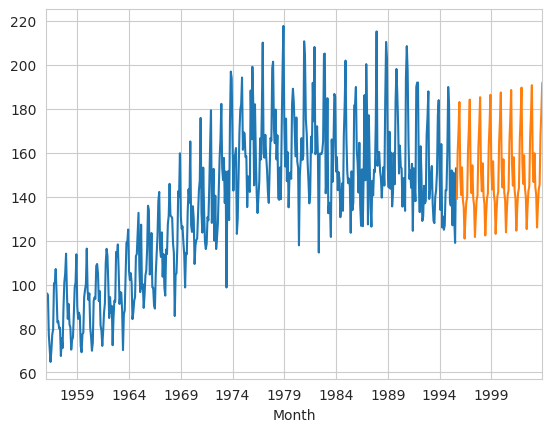

In [59]:
# Viivakaavio tuotannusta
df['Monthly beer production'].plot()

# Lisätään ennuste viivakaavioon
df_ennuste['Ennuste'].plot()

Ennusteen trendi on loivasti ylöspäin.

In [60]:
# Tietokehikko, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df

,Monthly beer production,Ennuste,Ennustevirhe
Month,,,
1956-01-01,93.2,88.024488,5.175512
1956-02-01,96.0,83.084688,12.915312
1956-03-01,95.2,91.956006,3.243994
1956-04-01,77.1,83.620554,-6.520554
1956-05-01,70.9,81.134365,-10.234365
...,...,...,...
1995-04-01,127.0,135.855629,-8.855629
1995-05-01,151.0,131.396371,19.603629
1995-06-01,130.0,118.905896,11.094104
